In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import h5py
import numpy as np
import math

from sklearn.neural_network import MLPRegressor


In [2]:
# --- Matlab files
# mat_data = scipy.io.loadmat() DOES NOT WORK BEFORE 7.3

f = h5py.File('..//Matlab Code/MPC/building.mat','r')
for k in f.iterkeys():
    print k

b_mat = f.get('ssM/Bu').value.transpose()
b_d_mat = f.get('ssM/Bd').value.transpose()
a_mat = f.get('ssM/A').value.transpose()
c_mat = f.get('ssM/C').value.transpose()
x_0 = f.get('x0red').value.transpose()

env_cond = f.get('refDist')
env_cond_tempID = 0
env_cond_irrID = 1
env_cond_gainID = 2

dt = float(1.0/3.0)  # in hours

#refs#
refDist
sT
ssM
ssMFull
x0red


/usr/local/lib/python2.7/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


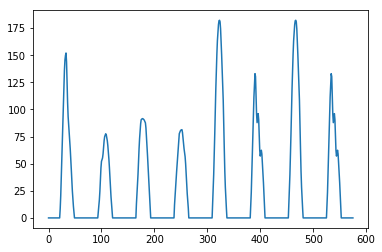

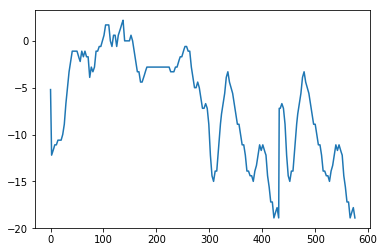

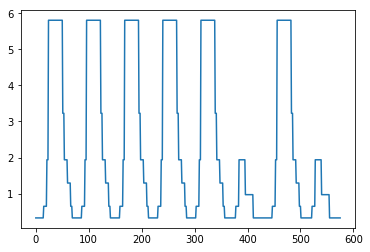

In [3]:
plt.plot(f.get('refDist')[:,env_cond_irrID])
plt.figure()
plt.plot(f.get('refDist')[:,env_cond_tempID])
plt.figure()
plt.plot(f.get('refDist')[:,env_cond_gainID])

In [4]:
# ------- METHODS TO SIMULATE THE SYSTEM, FOLLOWING A SPECIFIC MODEL ------ #

# The real model
def simulate_model(x, u, d):
    return np.matmul(a_mat, x) + np.matmul(b_mat, u) + np.matmul(b_d_mat, d)

# From x_state -> sensed temperatures
def get_room_temperature(x):
    return np.matmul(c_mat, x)

# Loop over time intervals to simulate various models
def simulate_system(iter_range, x_0, u_ctrl, rc_model=None, ann_model=None): 
    nb_iter = len(iter_range)
    
    # Real system
    x_realsys = np.zeros(shape=(nb_iter+1, 10))
    x_realsys[0] = x_0
    
    # Approximations
    x_rcmodel = np.zeros(shape=(nb_iter+1, 3))
    x_annmodel = np.zeros(shape=(nb_iter+1, 3))
    x_rcmodel[0,:] = get_room_temperature(x_0)
    x_annmodel[0,:] = get_room_temperature(x_0)
    
    # Main loop
    for i in range(nb_iter):
        t_idx = iter_range[i]
        x_old = np.array([x_realsys[i]]).transpose()
        x_new = simulate_model(x_old, u_ctrl[:,i].reshape((3,1)), f.get('refDist')[t_idx].reshape((3,1)))
        x_realsys[i+1] = x_new.transpose()
        
        if rc_model:
            x_rcmodel[i+1] = simulate_rc_model(rc_model, x_rcmodel[i], u_ctrl[:,i], f.get('refDist')[t_idx])
        
        if ann_model and i >= ann_model['nb_historic_pts']:
            nb_idx_past = ann_model['nb_historic_pts']
            x_annmodel[i+1] = simulate_ann_model(ann_model, x_rcmodel[i-nb_idx_past+1:i+1,:], u_ctrl[:,i-nb_idx_past+1:i+1], f.get('refDist')[i-nb_idx_past+1:i+1])
    
    return x_realsys, x_rcmodel, x_annmodel

# RC model
def simulate_rc_model(rc_model, t_vect, u, d):
    incr_var = [[(d[env_cond_tempID]-t_vect[r_id]), u[r_id], d[env_cond_irrID], d[env_cond_gainID]] for r_id in range(3)]
    return t_vect + [dt * np.matmul(rc_model[r_id], incr_var[r_id]) for r_id in range(3)]

# ANN model
def simulate_ann_model(ann_model, t_vect, u, d):
    nb_historic_pts = ann_model['nb_historic_pts']
    t_next = np.zeros(shape=(1,3))
    for r_id in range(3):
        list_idx = range(0,nb_historic_pts)
        list_idx.reverse()
        X_past = np.array([np.append(t_vect[j, r_id], np.append(u[r_id, j], d[j,:].flatten())).tolist() for j in list_idx]).flatten()
        t_next[0,r_id] = ann_model[r_id].predict([X_past])
        
    return t_next

# Generate a random control sequence
def generate_u_ctrl(nb_iter, freq_onoff=10):
    u_ctrl_learn = np.array(nb_iter * [[0, 0, 0]]).transpose() # np.random.rand(3, nb_iter)*10
    
    for i in range(nb_iter):
        if i%freq_onoff == 0 and i+freq_onoff/2 < nb_iter:
            k = np.random.rand()
            for j in range(freq_onoff/2):
                u_ctrl_learn[:,i+j] = [5 + 8 * k, 2 + 2 * k, 3 + 5 * k]
                
    return u_ctrl_learn

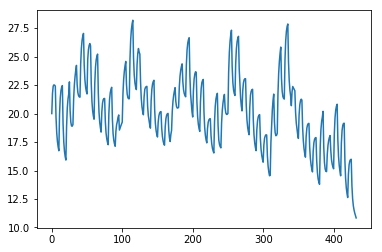

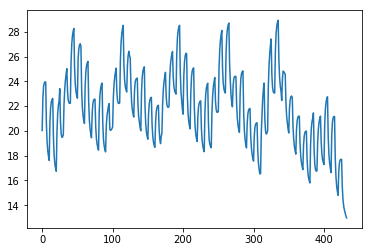

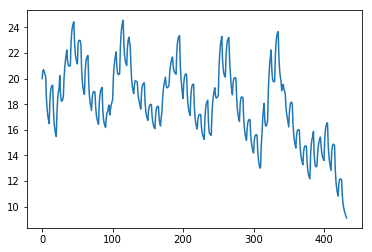

In [5]:
nb_iter_learn = 24 * 3 * 6

# Random u
u_learn_list = {}
t_learn_list = {}

for test_id in range(10):
    u_ctrl_learn = generate_u_ctrl(nb_iter_learn) #np.array(nb_iter_learn * [[0, 0, 0]]).transpose()# 
    x_sys, t_approx, t_ann = simulate_system(range(nb_iter_learn), x_0.transpose()[0], u_ctrl_learn)
    temp_ulearn = np.array([get_room_temperature(x_sim.transpose()) for x_sim in x_sys])
    u_learn_list[test_id] = u_ctrl_learn
    t_learn_list[test_id] = temp_ulearn

# Constant u
# u_ctrl_learn2 = np.array(nb_iter_learn * [[1, 1, 1]]).transpose()
# x_sys2, t_approx2, t_ann2 = simulate_system(range(nb_iter_learn), x_0.transpose()[0], u_ctrl_learn2)
# temp_ulearn2 = np.array([get_room_temperature(x_sim.transpose()) for x_sim in x_sys2])
# u_learn_list[10] = u_ctrl_learn2
# t_learn_list[10] = temp_ulearn2

for r_id in range(3):
    ax = plt.figure()
    plt.plot(temp_ulearn[:,r_id])

In [7]:
#
# --------- IDENTIFICATION OPTIMAL RC ------------ #
#

def get_ab_param_identif(room_id, temp_learn, u_learn, d_learn):
    
    n = len(d_learn)
    
    # --- APPEND u_rand
    A_learn = np.zeros(shape=(n, 4))

    # Construction of A
    A_learn[:,3] = dt * d_learn[:, env_cond_gainID]  # Internal gain
    A_learn[:,2] = dt * d_learn[:, env_cond_irrID]  # Irradiance
    A_learn[:,1] = dt * u_learn[room_id]  # HVAC
    A_learn[:,0] = dt * (d_learn[:, env_cond_tempID] - temp_learn[:-1,room_id])  # Outside temperature

    # Construction of b
    b_learn = (temp_learn[1:,room_id].reshape((n, 1)) - temp_learn[:-1,room_id].reshape((n, 1)))
    return A_learn, b_learn

# Concatenate datasets
rc_param = {}

# for r_id in range(3):
#     rc_param[r_id] = param_identif(r_id, temp_ulearn, u_ctrl_learn, env_cond[:nb_iter_learn,:])

for r_id in range(3):
    a_acc = None
    b_acc = None
    
    for k in u_learn_list.keys():
        a, b = get_ab_param_identif(r_id, t_learn_list[k], u_learn_list[k], env_cond[:nb_iter_learn,:])
        
        if a_acc is None:
            a_acc = a
        else:
            a_acc = np.append(a_acc, a, axis=0)
            
        if b_acc is None:
            b_acc = b
        else:
            b_acc = np.append(b_acc, b, axis=0)
    
    param = np.linalg.lstsq(a, b)
    rc_param[r_id] = param[0].reshape((1,4))[0]
    
rc_param

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


{0: array([0.12652025, 0.63354561, 0.01224086, 0.02141683]),
 1: array([0.1258292 , 2.31849247, 0.012193  , 0.02402383]),
 2: array([0.08313049, 0.61182188, 0.0103349 , 0.02156336])}

In [8]:
#
# --------- ANN TEST ------------ #
#

nb_historic_pts = 6  # X hours

# Room 0 temperature estimation

def get_ann_regressor(r_id):
    
    n_features = 5 * nb_historic_pts  # 5m: temp, u & 3 env var
    m_layers = 5
    v = m_layers * [n_features]
    ann_predictor = MLPRegressor(hidden_layer_sizes=(v))

    X_train = np.zeros(shape=(nb_iter_learn-nb_historic_pts, n_features))
    Y_train = np.zeros(shape=(nb_iter_learn-nb_historic_pts, 1))

    for i in range(nb_historic_pts, nb_iter_learn):
        X_train[i-nb_historic_pts,:] = np.array([np.append(temp_ulearn[i-j-1,r_id], np.append(u_ctrl_learn[r_id, i-j-1], env_cond[i-j-1,:].flatten())).tolist() for j in range(nb_historic_pts)]).flatten()
        Y_train[i-nb_historic_pts] = temp_ulearn[i, r_id]

    X_train_df = pd.DataFrame(X_train)

    ann_predictor.fit(X_train_df, Y_train)
    
    return ann_predictor, X_train_df

# Train the models
ann_regressors = {}
ann_regressors['nb_historic_pts'] = nb_historic_pts
df_last = 0
for r_id in range(3):
    ann_regressors[r_id], df = get_ann_regressor(r_id)
    df_last = df


/home/olivier/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


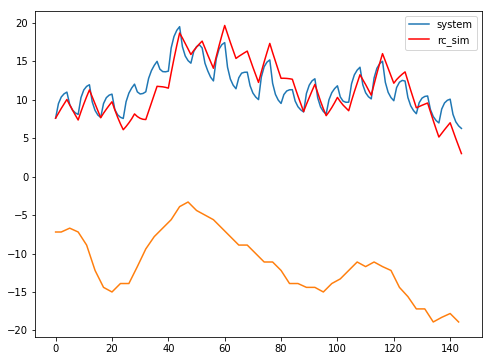

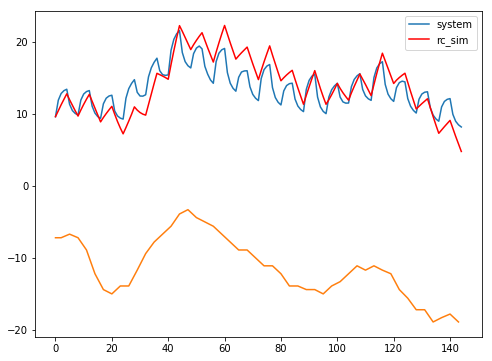

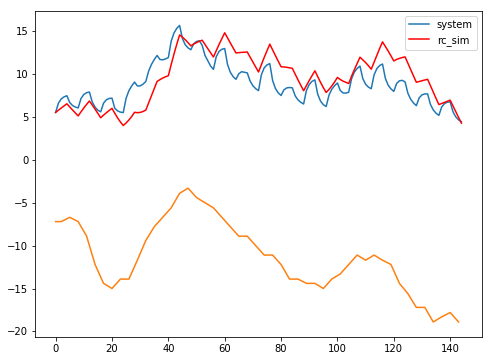

In [11]:
#
# ------- TEST SIMULATION AFTER LEARNING
#

nb_iter_test = 24 * 3 * 2
test_range = range(nb_iter_learn, nb_iter_learn + nb_iter_test)

u_ctrl_test = generate_u_ctrl(nb_iter_test, 8) #np.array(nb_iter_test * [[0, 0, 0]]).transpose() #

x_init = x_sys[-1]
x_sys, t_approx_rc, t_approx_ann = simulate_system(test_range, x_init, u_ctrl_test, rc_model=rc_param, ann_model=None)

temp_utest = np.array([get_room_temperature(x_sim.transpose()) for x_sim in x_sys])

for r_id in range(3):
    ax = plt.figure(figsize=(8,6))
    plt.plot(temp_utest[:,r_id], label='system')
    plt.plot(t_approx_rc[:,r_id], 'r-', label='rc_sim')
#     plt.plot(t_approx_ann[:,r_id], 'g--', label='ann_sim')
#     plt.plot(f.get('refDist')[:,env_cond_irrID])
    plt.plot(f.get('refDist')[test_range,env_cond_tempID])
#     plt.plot(f.get('refDist')[:,env_cond_gainID])
    plt.legend()